### Development notes

Define _messiness_ as variations in data types or completeness.
Define _noise_ as outliers.

1. Create noise arguments in add_arrays:
    * Research best method. Probably overlaying (by addition or multiplication) another random distribution.
    * What argument to accept? Float between 0 and 1, where 0 is no noise, and 1 makes the array completely random?
2. Create messiness:
    * Apply messiness arguments to each feature after generating the dataframe.
    * Let user specify percent of data that would be NaN.
    * Let user specify percent of data that's incorrect type. (e.g., value = str(numerical_value); float_value = int(float_value))
    * Let user specify percent of outliers.
3. Downcasting in _make_arrays:
    * Allow arrays to have other numerical data types. What if the distributions yield integers?


### Currently working on ...

**Runtime optimization**
* Analyze operation run times.

**Make noise**
* Add noise arguments to add_feature as integer (percent value)
* Try: with resulting dataframe, make mask of indicies. Apply value * random_scaling_factor


In [1]:
import pandas
import numpy

import seaborn
import matplotlib.pyplot as plt

%matplotlib inline


#DEBUGGING
from pprint import pprint
from time import time


In [2]:
class Pseudodata:
    """
    Anticipated workflow
    1. Create Pseudodata instance.
    2. Add two or more distribution arrays.
    3. Generate an output pseudodata DataFrame from the distribution arrays.
    4. Add an additional array to the dataset. Give option to update the pseudodata DataFrame automatically or manually (with method).
    5. Output the pseudodata DataFrame as Pandas object. OPTIONAL OTHER FORMATS?
    6. VISUALIZE THE DATAFRAME?
    
    Development plan
    * Make function_string formatter, so that most input string are modified to be evaluatable as callable functions. (Including size arguments for Numpy distribution methods.)
    * Make data generation lazy. Adding distributions should only automatically update the data_profile dictionary; the user can change the option or run generate_dataframe or update_dataframe.
    * Allow add_array to use non-Numpy distribution functions.
    * Allow allow arrays to be regenerated so a new sample can be drawn from the same distribution.
    * Allow non-numerical data arrays; i.e., text. (MAP STRING VALUES TO NUMBERS, THEN SUBSTITUTE BACK AFTER MAKING DATAFRAME?)
    
    Ideas to consider
    * "dataframe" objects are tuples of the DataFrames and snapshots of data_profiles used for generation. I.e., dataframe = (data_profile, pandas.DataFrame).
    * Distribution arrays should be stored. Advantage: able to reference values later and reconstruct DataFrame objects. Disadvantage: memory storage.
    * DataFrames are best visualized with pairplots, especially for multiple (2+) dimensions.
    * Users should have the option to export DataFrames as CSVs and SQL files.
    """
    reduced_memory = bool
    data_profile = dict()
    features_data = dict()
    dataframe = pandas.DataFrame()
    
    def __init__(self, conserve_memory=False):
        """Downcast datatypes to reduce memory allocations."""
        self.reduced_memory = conserve_memory
        self._check_setup()
        self.data_profile = dict()
        self.features_data = dict()
        self.dataframe = pandas.DataFrame()
    
    def __call__(self):
        # WHAT DOES THIS DO?
        pass
    
    def _check_setup(self):
        try:
            modules
        except:
            from sys import modules
        
        for module in ['pandas', 'numpy']:
            if module not in modules:
                print("{} not imported".format(module))

    def show_data_profile(self):
        """Displays a description of the arrays in the Pseudodata instance as a DataFrame object."""
        return pandas.DataFrame(self.data_profile).T

    def list_available_distributions(self, detailed_list=False):
        """Returns a list of the univariate distributions available in numpy.random."""
        rand_docstring = numpy.random.__doc__
        prefiltered_doc_string = rand_docstring.split('variate distributions')[1].split('\n')
        dist_filter = filter(lambda x: 'distribution' in x, prefiltered_doc_string)
        dist_list = [element.split(' ')[0] for element in dist_filter]
        
        if detailed_list == False:
            return dist_list
        else:
            detailed_dist_list = list()
            for distribution in dist_list:
                dist_docstring = eval("numpy.random.{}.__doc__".format(distribution))
                details = dist_docstring.split('\n')[1].strip()
                detailed_dist_list.append(details)
            return detailed_dist_list    

    def _is_evaluatable(self, input_string):
        """Tests if a string refers to an object that can be evaluated."""
        try:
            eval(input_string)
            return True
        except:
            return False

    def _is_callable(self, input_string):
        """Tests if a string refers to a callable object."""
        try:
            return callable(eval(input_string))
        except:
            return False

    def _add_size(self, input_string, size):
        """Adds a size argument to distribution function string if applicable."""
        if 'size' in input_string or size == None:
            return input_string
        elif '()' in input_string:
            return input_string.replace('()', '(size={0})'.format(size))
        else:
            return input_string.replace(')', ', size={0})'.format(size))

    def _format_function_string(self, input_string, size_argument=None):
        """IN PROGRESS: use "test" decorator
        Makes any necessary changes to the distribution function string so that it can make feature data."""
        if input_string.split('(')[0] in self.list_available_distributions():
            input_string = 'numpy.random.{0}'.format(input_string)
        if self._is_evaluatable(input_string) == False:
            return input_string
        callable_string_cases = {True: input_string + "()", 
                                 False: input_string}
        callable_string = callable_string_cases.get(self._is_callable(input_string))
        test_string = self._add_size(callable_string, size_argument)
        try:
            eval(test_string)
            return test_string
        except:
            return callable_string
    
    def _make_data_array(self, distribution='normal', list_len=10):
        """Creates a 1-D Numpy array of specified length using the specified univariate distribution function from Numpy.random."""
        function_string = self._format_function_string(input_string=distribution, size_argument=list_len)
        test_value = eval(function_string)
        if isinstance(test_value, type(numpy.array([]))) or isinstance(test_value, list):
            result = eval(function_string)
        else:
            result = [eval(function_string) for _ in range(list_len)]
        result_array = numpy.array(result)
        if self.reduced_memory == True:
            result_array = result_array.astype('float32', casting='same_kind')
        return result_array

    def _make_Nd_dataframe(self, arrays):
        """Handles N-dimensions."""
        grid = numpy.meshgrid(*arrays)
        transposed_grid = numpy.transpose(grid)
        raveled_grid = transposed_grid.ravel()
        reshaped_grid = raveled_grid.reshape(-1, len(arrays))
        product_array = numpy.product(reshaped_grid, axis=1)
        sorted_index = product_array.argsort()
        dataframe = pandas.DataFrame(reshaped_grid[sorted_index, :], index=product_array[sorted_index])
        dataframe.columns = ["feature_{0}".format(column) for column in dataframe.columns]
        return dataframe
    
    def add_feature(self, distribution='normal', size=10, remake_dataframe=False):
        """Adds a data array to the Pseudodata instance. 
        Refer to Pseudodata.list_available_distributions() to see available distibution options. Examples:
        Pseudodata_instance.add_array()
        Pseudodata_instance.add_array(distribution='poisson')
        Pseudodata_instance.add_array(distribution='binomial(10, .5, size=10)')
        Pseudodata_instance.add_array(distribution='logistic(loc=5.0, scale=2.0)', size=10)
        """
        data_array = self._make_data_array(distribution=distribution, list_len=size)
        feature_id = max(self.data_profile.keys(), default=-1) + 1
        self.data_profile[feature_id] = {'size': data_array.shape[0], 'distribution': distribution}
        self.features_data[feature_id] = data_array
        if remake_dataframe == True:
            self._make_Nd_dataframe(self.features_data.values())

    def remove_feature(self, feature_index, remake_dataframe=False):
        """Removes a feature by data profile index."""
        self.data_profile.pop(feature_index, None)
        self.features_data.pop(feature_index, None)
        if remake_dataframe == True:
            self._make_Nd_dataframe(self.features_data.values())
            
#     def remove_all_features(self, clear_dataframe=False):
#         """Deletes all data features, with an option to remove the DataFrame."""
#         self.data_profile = dict()
#         self.features_data = dict()
#         if clear_dataframe == True:
#             self.dataframe = pandas.DataFrame()
            
    def generate_dataframe(self, feature_index=None, reduce_memory=False):
        """Returns pandas.DataFrame.
        Generates a new dataframe from all features in the Pseudodata instance or from a specified list of data profile indicies.
        There is an option to reduce memory size of the dataframe by downcasting, which can significantly cut memory by reducing data precision."""
        if feature_index != None:
            for item in feature_index:
                if item not in self.data_profile:
                    raise KeyError("{0} is not in the data profile.".format(item))
            filtered_features_data = [self.features_data.get(key) for key in feature_index]
            feature_array = numpy.array(filtered_features_data)
            self.dataframe = self._make_Nd_dataframe(feature_array)
            # APPLY MESSINESS ARGUMENTS
            return self.dataframe
        else:
            self.dataframe = self._make_Nd_dataframe(self.features_data.values())
            # APPLY MESSINESS ARGUMENTS
            return self.dataframe

    def regenerate_feature(self, feature_index):
        """Resamples a specific feature according to its data profile index."""
        feature_details = self.data_profile.get(feature_index)
        data_array = self._make_data_array(feature_details['size'], feature_details['distribution'])
        self.features_data[feature_index] = data_array

# Making outliers

In [3]:
test_arrays = [numpy.random.normal(size=10000) for _ in range(2)]
test_dataframe = pandas.DataFrame(test_arrays).T

pprint(test_dataframe.head(5))


          0         1
0  2.039218  1.314775
1 -1.125146 -0.117322
2 -0.381073 -0.602725
3 -1.227746 -0.315493
4 -0.887221  0.663475


In [28]:
def add_noise(series, noise_fraction=0, inplace=False):
    series_copy = series.copy()
    sample_index = series_copy.sample(frac=noise_fraction).index
    noise_scale_array = numpy.array([numpy.random.uniform() for _ in range(sample_index.shape[0])])
    noise_translation_array = numpy.array([numpy.random.uniform(low=series.min(), high=series.max()) for _ in range(sample_index.shape[0])])
    if inplace == False:
        series_copy.loc[sample_index] = series_copy.loc[sample_index] * noise_scale_array + noise_translation_array
        return series_copy
    else:
        series.loc[sample_index]  = series.loc[sample_index] * noise_scale_array + noise_translation_array

test_dataframe['1_with_noise'] = add_noise(test_dataframe.loc[:, 1], noise_fraction=.01)

In [31]:
%timeit add_noise(test_dataframe.loc[:, 1], noise_fraction=.01)


15.1 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
# (test_dataframe[1] != test_dataframe['1_with_noise']).sum()

# fig = plt.subplot()
# for column in [1, '1_with_noise']:
#     test_dataframe[column].sort_values().reset_index(drop=True).plot.line()
# plt.plot()

# (test_dataframe[1] - test_dataframe['1_with_noise']).hist()
# plt.plot()

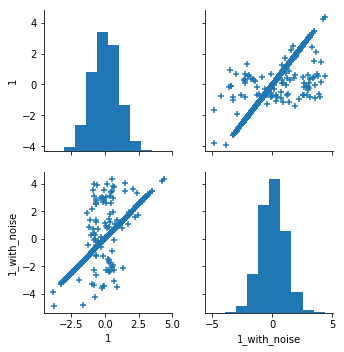

In [30]:
seaborn.pairplot(test_dataframe[[1, '1_with_noise']], markers='+')

# Testing for duplicates

In [ ]:
test_pseudodata = Pseudodata(conserve_memory=False)

for _ in range(4):
    test_pseudodata.add_feature(size=30)

test_dataframe = test_pseudodata.generate_dataframe()

test_dataframe.info()


In [ ]:
duplicate_row_count = test_dataframe.shape[0] - test_dataframe.drop_duplicates().shape[0]

if duplicate_row_count == 1:
    print(f"{duplicate_row_count} row was a duplicate.")
else:
    print(f"{duplicate_row_count} rows were duplicates.")

# Performance time testing

In [ ]:
# test_pseudodata = Pseudodata(conserve_memory=False)

# for _ in range(4):
#     test_pseudodata.add_feature(size=70)

# def timed_make_Nd_dataframe(pseudodata_obj):
#     """Handles N-dimensions."""
#     time_log = []
#     start_time = time()
    
#     arrays = pseudodata_obj.features_data.values()
#     time_log.append(('Init array', time()))
                    
#     grid = numpy.meshgrid(*arrays)
#     time_log.append(('Make meshgrid', time()))
    
#     transposed_grid = numpy.transpose(grid)
#     time_log.append(('Transpose grids', time()))
    
#     raveled_grid = transposed_grid.ravel()
#     time_log.append(('Ravel grid', time()))
    
#     reshaped_grid = raveled_grid.reshape(-1, len(arrays))
#     time_log.append(('Reshape grid', time()))

#     product_array = numpy.product(reshaped_grid, axis=1)
#     time_log.append(('Make product array', time()))

#     sorted_index = product_array.argsort()
#     time_log.append(('Sort product array', time()))

#     dataframe = pandas.DataFrame(reshaped_grid[sorted_index, :], index=product_array[sorted_index])
#     time_log.append(('Convert array to DataFrame', time()))

#     dataframe.columns = ["feature_{0}".format(column) for column in dataframe.columns]
#     time_log.append(('Rename columns', time()))
#     return dataframe, time_log

    
# def process_time_log(time_log):
#     print("Runtime: {0:.6f} seconds.".format(time_log[-1][1] - time_log[0][1]))
#     time_df = pandas.DataFrame(time_log)
#     time_df['step_times'] = time_df[1].diff()

#     pprint(time_df[[0, 'step_times']])
    
    
# df, time_log = timed_make_Nd_dataframe(test_pseudodata)
# process_time_log(time_log)

# Demonstration of functionality

### General usage

In [ ]:
pseudodata = Pseudodata()


In [ ]:
pseudodata.list_available_distributions(detailed_list=True)[0:5]


In [ ]:
pseudodata.add_feature()
pseudodata.add_feature(size=100)
pseudodata.add_feature(size=5, distribution='poisson')
pseudodata.add_feature(distribution='normal(loc=5, size=100)')

my_generator = (number / 37.0 for number in range(38))
def my_function():
    global my_generator
    try:
        return next(my_generator)
    except:
        my_generator = (number / 37.0 for number in range(38))
        return next(my_generator)
pseudodata.add_feature(distribution='my_function', size=50)

pseudodata.show_data_profile()


In [ ]:
test_df = pseudodata.generate_dataframe()
print("{0:,} rows, {1} columns.".format(*test_df.shape))
test_df.head()


In [ ]:
test_df.hist()
plt.plot()


### Comparing memory savings


In [ ]:
regular_instance = Pseudodata()

for _ in range(4):
    regular_instance.add_feature(size=50)

%timeit regular_instance.generate_dataframe()
regular_instance.generate_dataframe().info()


In [ ]:
reduced_instance = Pseudodata(conserve_memory=True)

for _ in range(4):
    reduced_instance.add_feature(size=50)

%timeit reduced_instance.generate_dataframe()
reduced_instance.generate_dataframe().info()


# Experimental Features

### String formatting cleanup

In [ ]:
my_var = 10
italian_dict = {10: "dieci"}

print(f"Ci sono {my_var} mele.")
print("Ci sono {0} mele".format(italian_dict[my_var]))

### Formatting function strings
Make `test` wrapper to contain `try`/`except` block.

In [ ]:
# def test(function):
#     def wrapper(*args):
#         function(*args)
#     return wrapper

def test(function):
    def wrapper(*args):
        try:
            print("Function result:", function(*args))
            return True
        except:
            return False
    return wrapper

@test
def iscallable(string):
    """Tests if the string represents a callable function."""
    return callable(eval(string))

@test
def iseval(string):
    """Tests if the string represents an evaluatable object."""
    return eval(string)

# print(iseval(1))
# print(iseval("1"))
# print(eval("1"))

print(iscallable("1"))
print(callable(eval(1)))


### Method chaining

Example

>`Pseudodata().add_array(100).add_array('binomial(10,0.5)').generate_dataframe()`

In [ ]:
class Test:
    value = list()
    def __init__(self):
        self.value = [1]
    
    def add_one(self, inplace=False):
        self.value.append(self.value[-1] + 1)
        return self
    
    def print_value(self):
        print(self.value)
        
b = Test()
b.add_one().add_one().add_one().add_one()
print("b.print_value():", b.print_value())



# Deprecated working methods

In [ ]:
# # OBSOLECENSE TIMELINE UNKNOWN
# def make_dataframe(array_1=None, array_2=None):
#     """Create a DataFrame from the elementwise product of two iterables."""
    
#     if array_1 is None or array_2 is None:
#         return None
    
#     if array_1.shape[0] < array_2.shape[0]:
#         index_array = array_1
#         column_array = array_2
#     else:
#         index_array = array_2
#         column_array = array_1

#     result_dataframe = pd.DataFrame(index=index_array, columns=column_array)
#     for row in result_dataframe.iterrows():
#         result_dataframe.loc[row[0]] = row[0] * result_dataframe.columns
#     return result_dataframe


# # PHASED OUT 4-July-2018
# # MADE OBSOLETE BY make_Nd_dataframe
# def _make_dataframe(self, array_1=None, array_2=None):
#     """Create a DataFrame from the elementwise product of two iterables."""

#     result_dataframe = pd.DataFrame(index=array_1, columns=array_2)

#     # Iterative operations are generally faster if row length is greater than the number of columns.
#     if result_dataframe.shape[0] < result_dataframe.shape[1]:
#         result_dataframe = result_dataframe.T

#     result_dataframe = result_dataframe.apply(lambda series: series.index) * result_dataframe.columns

#     return result_dataframe

# # PHASED OUT 4-July-2018
# # PAIRED WITH _make_dataframe
# # MADE OBSOLETE BY make_Nd_dataframe
# def _invert_dataframe(self, input_dataframe=None):
#     """Inverts a DataFrame, where the values become the index and the column and row indicies become values."""
#     if input_dataframe is None:
#         return None
#     reshaped_dataframe = input_dataframe.stack().reset_index().set_index(0)
#     feature_count = reshaped_dataframe.shape[1]
#     feature_names = list(range(feature_count))
#     reshaped_dataframe.columns = feature_names
#     return reshaped_dataframe.sort_index()


# # PHASED OUT 20-July-2018
# # MADE OBSOLETE BY: SEE COMMENT
# def _make_Nd_dataframe(self, arrays):
#     """Handles N-dimensions."""
#     grid = numpy.meshgrid(*arrays)
#     transposed_grid = numpy.transpose(grid)
#     reshaped_grid = numpy.dstack(transposed_grid).reshape(-1, len(arrays))  #Replacing dstack with ravel significantly reduces reshape time.
#     dataframe = pandas.DataFrame(reshaped_grid)
#     products = dataframe.product(axis=1)
#     dataframe.index = products
#     dataframe.columns = ["feature_{0}".format(column) for column in dataframe.columns]
#     dataframe = dataframe.sort_index()
#     return dataframe


# # PHASED OUT 25-July-2018
# # MADE OBSOLETE BY: various improvements using Numpy.
# def _make_Nd_dataframe(self, arrays):
#     """Handles N-dimensions."""
#     grid = numpy.meshgrid(*arrays)
#     transposed_grid = numpy.transpose(grid)
#     reshaped_grid = transposed_grid.ravel().reshape(-1, len(arrays))
#     dataframe = pandas.DataFrame(reshaped_grid) 
#     products = dataframe.product(axis=1)
#     dataframe.index = products
#     dataframe.columns = ["feature_{0}".format(column) for column in dataframe.columns]
#     dataframe = dataframe.sort_index()
#     return dataframe